In [1]:
from auton_survival import datasets

outcomes, features = datasets.load_support()

/home/fywang/miniconda3/envs/survival/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from auton_survival.preprocessing import Preprocessor

cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp',
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph',
             'glucose', 'bun', 'urine', 'adlp', 'adls']

features = Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)

import numpy as np

horizons = [0.25, 0.5, 0.75]
times = np.quantile(outcomes.time[outcomes.event == 1], horizons).tolist()

x, t, e = features.values.astype(float), outcomes.time.values.astype(float), outcomes.event.values.astype(float)

n = len(x)

tr_size = int(n * 0.70)
vl_size = int(n * 0.10)
te_size = int(n * 0.20)

print(tr_size, vl_size, te_size)

x_train, x_test, x_val = x[:tr_size], x[-te_size:], x[tr_size:tr_size + vl_size]
t_train, t_test, t_val = t[:tr_size], t[-te_size:], t[tr_size:tr_size + vl_size]
e_train, e_test, e_val = e[:tr_size], e[-te_size:], e[tr_size:tr_size + vl_size]

6373 910 1821


In [3]:
x_train[0].shape

(38,)

In [5]:
models = []

from auton_survival.models.dpsm import DeepDP
from auton_survival.models.dsm import DeepSurvivalMachines

# model = DeepDP(k=3,
#                distribution='LogNormal',
#                layers=[100])
model = DeepSurvivalMachines(
    k=4,
    distribution="LogNormal",
    # distribution="Weibull",
    layers=[100]
)
# The fit method is called to train the model
model.fit(x_train, t_train, e_train, iters=100, learning_rate=0.001)

 23%|██▎       | 23/100 [00:04<00:16,  4.65it/s]


In [6]:
trained_weights = model.trained_weights
print(trained_weights.shape)

(24, 5418, 4)


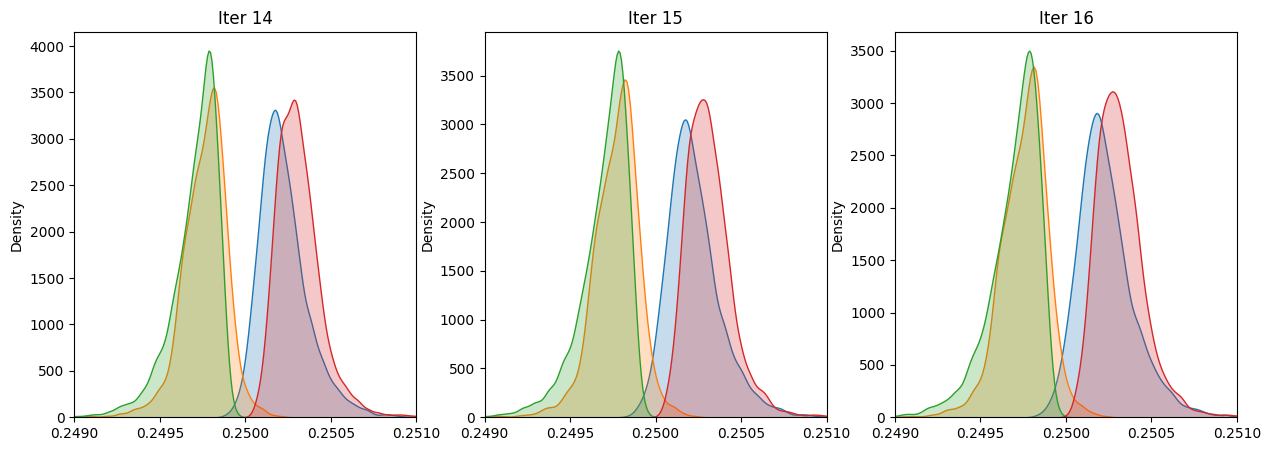

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

figs, axes = plt.subplots(1, 3, figsize=(15, 5))
iter_idx = [14, 15, 16]

for idx in range(3):
    sns.kdeplot(trained_weights[iter_idx[idx]][:, 0], fill=True, ax=axes[idx])
    sns.kdeplot(trained_weights[iter_idx[idx]][:, 1], fill=True, ax=axes[idx])
    sns.kdeplot(trained_weights[iter_idx[idx]][:, 2], fill=True, ax=axes[idx])
    sns.kdeplot(trained_weights[iter_idx[idx]][:, 3], fill=True, ax=axes[idx])
    axes[idx].set_title(f'Iter {iter_idx[idx]}')
    axes[idx].set_xlim(0.249, 0.251)

# sns.kdeplot(trained_weights[iter_idx][:, 0], fill=True)
# sns.kdeplot(trained_weights[iter_idx][:, 1], fill=True)
# sns.kdeplot(trained_weights[iter_idx][:, 2], fill=True)
# plt.title(f'Iter {iter_idx}')